# Makine Öğrenmesi ile Yetenek Avcılığı Sınıflandırma

### İş Problemi
Scout’lar tarafından izlenen futbolcuların özelliklerine verilen puanlara göre, oyuncuların hangi sınıf(average, highlighted) oyuncu olduğunu tahminleme.

Scout: Gözlemci ya da yetenek avcısı, gelecek vadettiği düşünülen sporcuları gözlemleyerek mevcut yeteneklerini ve potansiyellerini tespit eden uzman kişi

### Veri Seti Hikayesi
Veri seti Scoutium’dan maçlarda gözlemlenen futbolcuların özelliklerine göre scoutların değerlendirdikleri futbolcuların, maç
içerisinde puanlanan özellikleri ve puanlarını içeren bilgilerden oluşmaktadır.

##### scoutium_attributes.csv
- task_response_id : Bir scoutun bir maçta bir takımın kadrosundaki tüm oyunculara dair değerlendirmelerinin kümesi
- match_id : Maçın id’si
- evaluation_id : Değerlendirici id’si
- player_id : Oyuncunun id’si
- position_id : Oyuncunun pozisyonu
        - 1. Kaleci
        - 2. Stopper
        - 3. Sağ Bek
        - 4. Sol Bek
        - 5. Defansif Orta Saha
        - 6. Merkezi Orta Saha
        - 7. Sağ Kanat
        - 8. Sol Kanat
        - 9. Ofansif Orta Saha
        - 10. Forvet
- analysis_id : Bir scoutun bir maçta bir oyuncuya dair özellik değerlendirmelerini içeren küme
- attribute_id : Oyuncuların değerlendirildiği her bir özelliğin id'si
- attribute_value : Bir scoutun bir oyuncunun bir özelliğine verdiği değer(puan)

##### scoutium_potential_labels.csv
- task_response_id :  Bir scoutun bir maçta bir takımın kadrosundaki tüm oyunculara dair değerlendirmelerinin kümesi
- match_id : İlgili maçın id'si
- evaluator_id :  Değerlendiricinin(scout'un) id'si
- player_id : İlgili oyuncunun id'si
- potential_label : Bir scoutun bir maçta bir oyuncuyla ilgili nihai kararını belirten etiket. (hedef değişken)

Adım 1: scoutium_attributes.csv ve scoutium_potential_labels.csv dosyalarını okutunuz.


In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.model_selection import *
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_predict
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv("scoutium_attributes.csv",sep=";")
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value
0,4915,62935,177676,1361061,2,12818495,4322,56.000
1,4915,62935,177676,1361061,2,12818495,4323,56.000
2,4915,62935,177676,1361061,2,12818495,4324,67.000
3,4915,62935,177676,1361061,2,12818495,4325,56.000
4,4915,62935,177676,1361061,2,12818495,4326,45.000


In [3]:
df.shape

(10730, 8)

In [4]:
df2 = pd.read_csv("scoutium_potential_labels.csv",sep=";")
df2.head()

,task_response_id,match_id,evaluator_id,player_id,potential_label
0,4915,62935,177676,1361061,average
1,4915,62935,177676,1361626,highlighted
2,4915,62935,177676,1361858,average
3,4915,62935,177676,1362220,highlighted
4,4915,62935,177676,1364951,highlighted


In [5]:
df2.shape

(322, 5)

Adım 2: Okutmuş olduğumuz csv dosyalarını merge fonksiyonunu kullanarak birleştirelim.  ("task_response_id", 'match_id', 'evaluator_id' "player_id"  4 adet değişken üzerinden birleştirme işlemini gerçekleştiriniz.)


In [6]:
dff = pd.merge(df, df2, how='left', on=["task_response_id", 'match_id', 'evaluator_id', "player_id"])


Adım 3:  position_id içerisindeki Kaleci (1) sınıfını veri setinden kaldırınız.

In [7]:
dff = dff[dff["position_id"] != 1]

Adım 4: potential_label içerisindeki below_average sınıfını veri setinden kaldırınız.( below_average sınıfı tüm verisetinin %1'ini oluşturur)


In [8]:
dff=dff[dff["potential_label"]!="below_average"]


Adım 5: Oluşturduğunuz veri setinden “pivot_table” fonksiyonunu kullanarak bir tablo oluşturunuz. Bu pivot table'da her satırda bir oyuncu
olacak şekilde manipülasyon yapınız.
Görevler

    Adım 1: İndekste “player_id”,“position_id” ve “potential_label”, sütunlarda “attribute_id” ve değerlerde scout’ların oyunculara verdiği puan
    “attribute_value” olacak şekilde pivot table’ı oluşturunuz.

In [9]:
pt = pd.pivot_table(dff, values="attribute_value", columns="attribute_id", index=["player_id","position_id","potential_label"])


        #Adım2: "resert_index fonksiyonunu kullanarak, index hatasından kurtulunuz. # ve "attribute_id" sütunlarının isimlerini stringe çeviriniz.

In [10]:
pt = pt.reset_index(drop=False)

pt.columns = pt.columns.map(str)

Adım 6: Label Encoder fonksiyonunu kullanarak “potential_label” kategorilerini (average, highlighted) sayısal olarak ifade ediniz.


In [11]:
le = LabelEncoder()
pt["potential_label"] = le.fit_transform(pt["potential_label"])

Adım 7: Sayısal değişken kolonlarını “num_cols” adıyla bir listeye atayınız.


In [12]:
num_cols=pt.columns[3:]

Adım 8: Kaydettiğiniz bütün “num_cols” değişkenlerindeki veriyi ölçeklendirmek için StandardScaler uygulayınız.


In [13]:
scaler=StandardScaler()
pt[num_cols]=scaler.fit_transform(pt[num_cols])


Adım 9: Elimizdeki veri seti üzerinden minimum hata ile futbolcuların potansiyel etiketlerini tahmin eden bir makine öğrenmesi modeli
geliştiriniz. (Roc_auc, f1, precision, recall, accuracy metriklerini yazdırınız.)

In [14]:
y = pt["potential_label"]
X = pt.drop(["potential_label", "player_id"], axis=1)

models = [('LR', LogisticRegression()),
          ('KNN', KNeighborsClassifier()),
          ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('CatBoost', CatBoostClassifier(verbose=False)),
              ("LightGBM", LGBMClassifier())]



for name, model in models:
    print(name)
    for score in ["roc_auc", "f1", "precision", "recall", "accuracy"]:
        cvs = cross_val_score(model, X, y, scoring=score, cv=5).mean()
        print(score+" score:"+str(cvs))


LR
roc_auc score:0.8332276250880903
f1 score:0.5545454545454545
precision score:0.6825974025974025
recall score:0.4818181818181818
accuracy score:0.8451178451178452
KNN
roc_auc score:0.7462825933756166
f1 score:0.3825062656641604
precision score:0.8547619047619047
recall score:0.2636363636363636
accuracy score:0.8375084175084175
SVC
roc_auc score:0.8384073291050035
f1 score:0.06666666666666668
precision score:0.4


c:\Users\BERKCAN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\BERKCAN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\BERKCAN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


recall score:0.03636363636363636
accuracy score:0.8008080808080809
CART
roc_auc score:0.7315362931642001
f1 score:0.5346320346320346
precision score:0.5524098124098125
recall score:0.6060606060606061
accuracy score:0.7973737373737374
RF
roc_auc score:0.9047216349541932
f1 score:0.6136382623224729
precision score:0.9314285714285715
recall score:0.46060606060606063
accuracy score:0.8781144781144782
Adaboost
roc_auc score:0.8466878083157153
f1 score:0.622438449063836
precision score:0.7108730158730159
recall score:0.5848484848484848
accuracy score:0.8562289562289562
GBM
roc_auc score:0.8730091613812544
f1 score:0.5937556561085973
precision score:0.7612698412698412
recall score:0.4954545454545455
accuracy score:0.8561616161616161
XGBoost
roc_auc score:0.8540873854827342
f1 score:0.6078282828282828
precision score:0.732987012987013
recall score:0.55
accuracy score:0.8561616161616161
CatBoost
roc_auc score:0.8911557434813249
f1 score:0.5852240896358544
precision score:0.8933333333333333
reca

Adım 10: Değişkenlerin önem düzeyini belirten feature_importance fonksiyonunu kullanarak özelliklerin sıralamasını çizdiriniz.


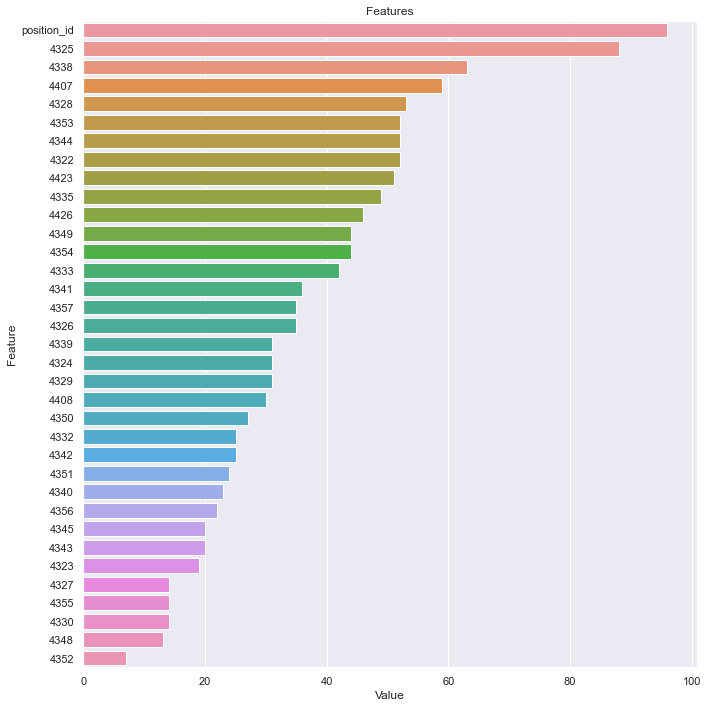

In [15]:
def plot_importance(model,features,num=len(X),save=False):
    feature_imp=pd.DataFrame({"Value":model.feature_importances_,"Feature":features.columns})
    plt.figure(figsize=(10,10))
    sns.set(font_scale=1)
    sns.barplot(x="Value",y="Feature",data=feature_imp.sort_values(by="Value",ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
model=LGBMClassifier()
model.fit(X,y)
plot_importance(model,X)